In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
sns.set(style="whitegrid")
# DPI stands for "dots per inch" and controls the resolution of the figure.
# A higher DPI value results in a more detailed (higher resolution) figure, which is useful for publications or printing.
# For example, to create a more detailed figure, you can increase the DPI:
plt.rcParams['figure.dpi'] = 200  # Increase DPI for more detailed (higher resolution) figures


In [2]:
# Load and prepare data
csv_files = glob.glob('cdf_data/*.csv')
df_cdf = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
print("CDF Data Info:")
print(df_cdf.info())

csv_files = glob.glob('cme_data/*.csv')
df_cme = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
print("\nCME Data Info:")
print(df_cme.info())

# Convert to datetime
df_cdf['datetime'] = pd.to_datetime(df_cdf['epoch_for_cdf_mod'])
df_cme['datetime'] = pd.to_datetime(df_cme['t0'])

# Sort data by datetime for better performance
df_cdf = df_cdf.sort_values('datetime').reset_index(drop=True)
df_cme = df_cme.sort_values('datetime').reset_index(drop=True)

print(f"\nDate range - CDF: {df_cdf['datetime'].min()} to {df_cdf['datetime'].max()}")
print(f"Date range - CME: {df_cme['datetime'].min()} to {df_cme['datetime'].max()}")
print(f"Total CME events: {len(df_cme)}")


CDF Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2699607 entries, 0 to 2699606
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   epoch_for_cdf_mod  object 
 1   proton_density     float64
 2   proton_bulk_speed  float64
 3   proton_xvelocity   float64
 4   proton_yvelocity   float64
 5   proton_zvelocity   float64
 6   proton_thermal     float64
 7   alpha_density      float64
 8   alpha_bulk_speed   float64
 9   alpha_thermal      float64
 10  spacecraft_xpos    float64
 11  spacecraft_ypos    float64
 12  spacecraft_zpos    float64
 13  source_file        object 
dtypes: float64(12), object(2)
memory usage: 288.3+ MB
None

CME Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964 entries, 0 to 963
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CME     964 non-null    int64 
 1   t0      964 non-null    object
 2   dt0     964 non-null    int64 

In [3]:
def create_optimized_seaborn_subplots(df_cdf, df_cme, sample_rate=100, figsize=(15, 20)):
    """
    Create optimized seaborn subplots with CME event highlighting
    
    Parameters:
    - sample_rate: Plot every Nth point for faster rendering
    - figsize: Figure size tuple
    """
    
    # Define the variables to plot
    plot_configs = [
        {'col': 'proton_density', 'title': 'Proton Density', 'ylabel': 'Density (particles/cm³)', 'color': 'blue'},
        {'col': 'proton_bulk_speed', 'title': 'Proton Bulk Speed', 'ylabel': 'Speed (km/s)', 'color': 'blue'},
        {'col': 'proton_thermal', 'title': 'Proton Thermal Speed', 'ylabel': 'Thermal Speed (km/s)', 'color': 'blue'},
        {'col': 'alpha_density', 'title': 'Alpha Particle Density', 'ylabel': 'Density (particles/cm³)', 'color': 'green'},
        {'col': 'alpha_bulk_speed', 'title': 'Alpha Particle Bulk Speed', 'ylabel': 'Speed (km/s)', 'color': 'green'},
        {'col': 'alpha_thermal', 'title': 'Alpha Particle Thermal Speed', 'ylabel': 'Thermal Speed (km/s)', 'color': 'green'},
    ]
    
    # Subsample data for faster plotting
    if len(df_cdf) > sample_rate:
        step = max(1, len(df_cdf) // sample_rate)
        df_plot = df_cdf.iloc[::step].copy()
    else:
        df_plot = df_cdf.copy()
    
    # Create subplots
    n_plots = len(plot_configs)
    fig, axes = plt.subplots(n_plots, 1, figsize=figsize, sharex=True)
    if n_plots == 1:
        axes = [axes]
    
    # Plot each variable
    for i, config in enumerate(plot_configs):
        ax = axes[i]
        
        # Filter out NaN values
        mask = df_plot[config['col']].notna()
        plot_data = df_plot[mask]
        
        if len(plot_data) > 0:
            # Plot the time series
            ax.plot(plot_data['datetime'], plot_data[config['col']], 
                   color=config['color'], linewidth=0.5, alpha=0.8)
            
            # Add CME event lines
            for cme_time in df_cme['datetime']:
                ax.axvline(x=cme_time, color='red', linestyle='--', linewidth=0.75, alpha=0.15)
            
            # Formatting
            ax.set_title(f"{config['title']} (n={len(plot_data)} points)", fontsize=10)
            ax.set_ylabel(config['ylabel'], fontsize=9)
            ax.tick_params(axis='both', labelsize=8)
            ax.grid(True, alpha=0.3)
    
    # Format x-axis for bottom subplot
    axes[-1].set_xlabel('Datetime', fontsize=9)
    axes[-1].tick_params(axis='x', rotation=45)
    
    # Format x-axis dates
    for ax in axes:
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes

In [4]:
def create_velocity_components_subplot(df_cdf, df_cme, sample_rate=100, figsize=(15, 6)):
    """
    Create subplot for velocity components (X, Y, Z)
    """
    # Subsample data
    if len(df_cdf) > sample_rate:
        step = max(1, len(df_cdf) // sample_rate)
        df_plot = df_cdf.iloc[::step].copy()
    else:
        df_plot = df_cdf.copy()
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Add velocity components
    velocity_configs = [
        {'col': 'proton_xvelocity', 'label': 'X-velocity', 'color': 'blue'},
        {'col': 'proton_yvelocity', 'label': 'Y-velocity', 'color': 'green'},
        {'col': 'proton_zvelocity', 'label': 'Z-velocity', 'color': 'red'}
    ]
    
    for config in velocity_configs:
        mask = df_plot[config['col']].notna()
        plot_data = df_plot[mask]
        
        if len(plot_data) > 0:
            ax.plot(plot_data['datetime'], plot_data[config['col']], 
                   color=config['color'], linewidth=0.5, alpha=0.8, 
                   label=config['label'])
    
    # Add CME event lines
    for cme_time in df_cme['datetime']:
        ax.axvline(x=cme_time, color='red', linestyle='--', linewidth=0.75, alpha=0.15)
    
    # Formatting
    ax.set_title('Proton Velocity Components with CME Events')
    ax.set_ylabel('Velocity (km/s)')
    ax.set_xlabel('Datetime')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

In [5]:
def create_spacecraft_position_subplot(df_cdf, df_cme, sample_rate=100, figsize=(15, 6)):
    """
    Create subplot for spacecraft position components (X, Y, Z)
    """
    # Subsample data
    if len(df_cdf) > sample_rate:
        step = max(1, len(df_cdf) // sample_rate)
        df_plot = df_cdf.iloc[::step].copy()
    else:
        df_plot = df_cdf.copy()
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Add position components
    position_configs = [
        {'col': 'spacecraft_xpos', 'label': 'X-position', 'color': 'blue'},
        {'col': 'spacecraft_ypos', 'label': 'Y-position', 'color': 'green'},
        {'col': 'spacecraft_zpos', 'label': 'Z-position', 'color': 'red'}
    ]
    
    for config in position_configs:
        mask = df_plot[config['col']].notna()
        plot_data = df_plot[mask]
        
        if len(plot_data) > 0:
            ax.plot(plot_data['datetime'], plot_data[config['col']], 
                   color=config['color'], linewidth=0.5, alpha=0.8, 
                   label=config['label'])
    
    # Add CME event lines
    for cme_time in df_cme['datetime']:
        ax.axvline(x=cme_time, color='red', linestyle='--', linewidth=0.75, alpha=0.15)
    
    # Formatting
    ax.set_title('Spacecraft Position Components with CME Events')
    ax.set_ylabel('Position (km)')
    ax.set_xlabel('Datetime')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

In [6]:
def create_cme_event_summary(df_cme):
    """
    Create a summary of CME events
    """
    print(f"\n=== CME Event Summary ===")
    print(f"Total CME events: {len(df_cme)}")
    print(f"Date range: {df_cme['datetime'].min()} to {df_cme['datetime'].max()}")
    
    # Group by month
    df_cme['month'] = df_cme['datetime'].dt.to_period('M')
    monthly_counts = df_cme.groupby('month').size()
    print(f"\nMonthly CME counts:")
    for month, count in monthly_counts.items():
        print(f"  {month}: {count} events")
    
    return monthly_counts

In [7]:
def create_time_filtered_plots(df_cdf, df_cme, start_date, end_date, sample_rate=100):
    """
    Create plots for a specific time period
    """
    # Filter data
    df_cdf_filtered = df_cdf[(df_cdf['datetime'] >= start_date) & (df_cdf['datetime'] <= end_date)]
    df_cme_filtered = df_cme[(df_cme['datetime'] >= start_date) & (df_cme['datetime'] <= end_date)]
    
    print(f"Filtered data: {len(df_cdf_filtered)} CDF points, {len(df_cme_filtered)} CME events")
    
    # Create plots
    fig, axes = create_optimized_seaborn_subplots(df_cdf_filtered, df_cme_filtered, sample_rate)
    return fig, axes

Creating main subplots...


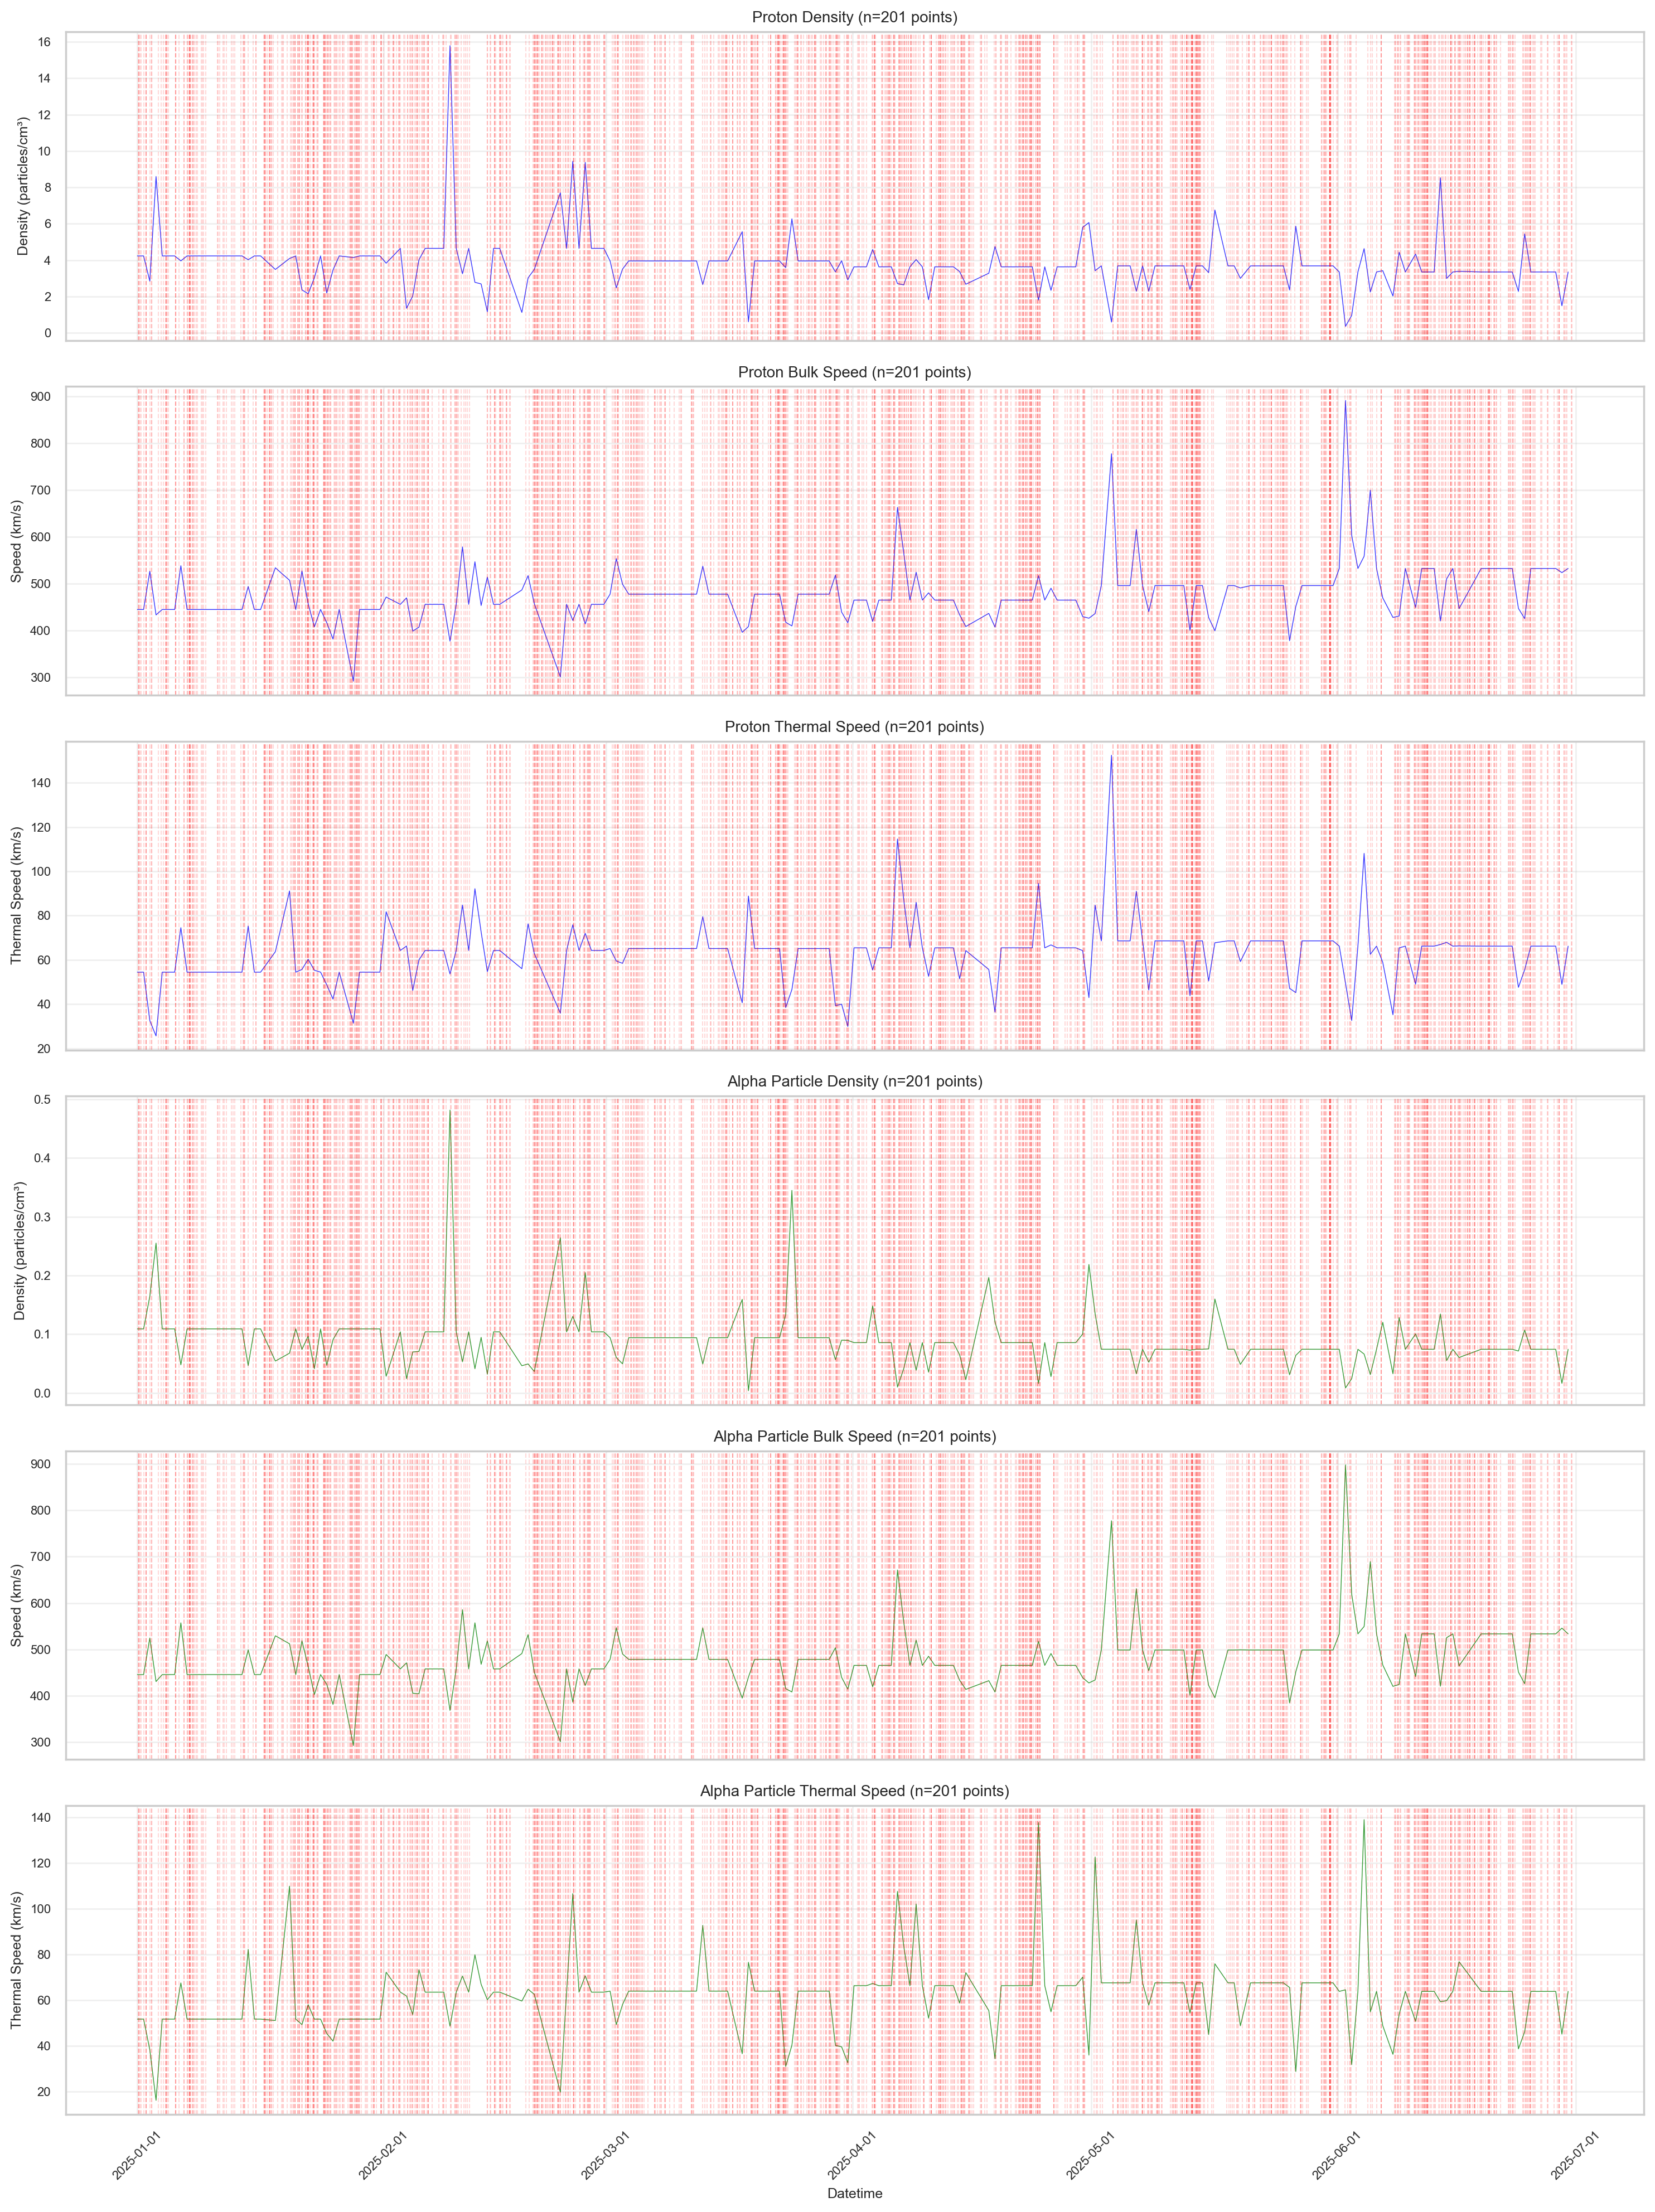

Creating velocity components subplot...


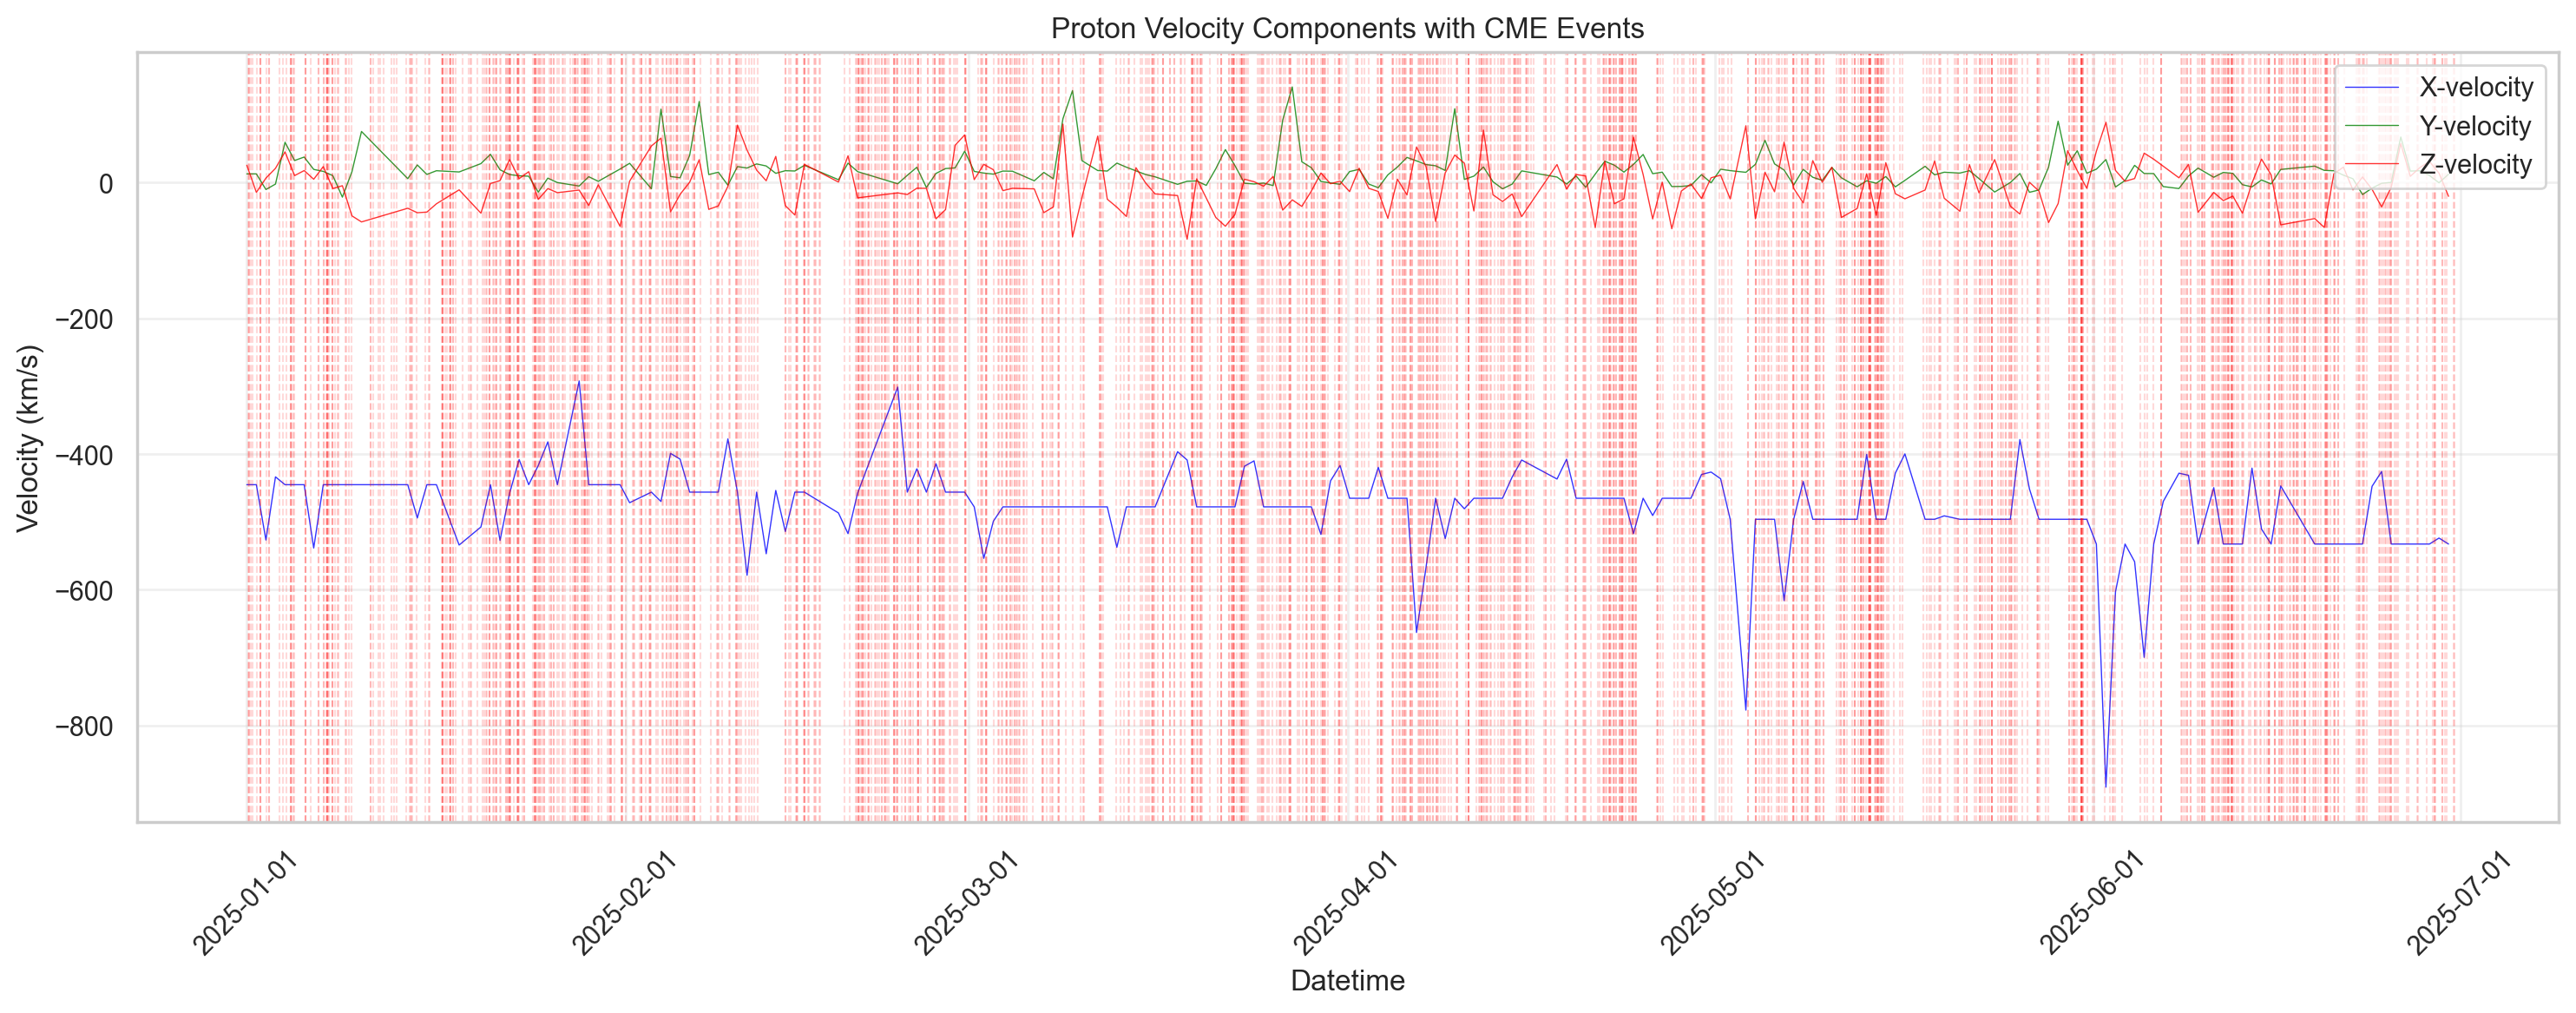

Creating spacecraft position subplot...


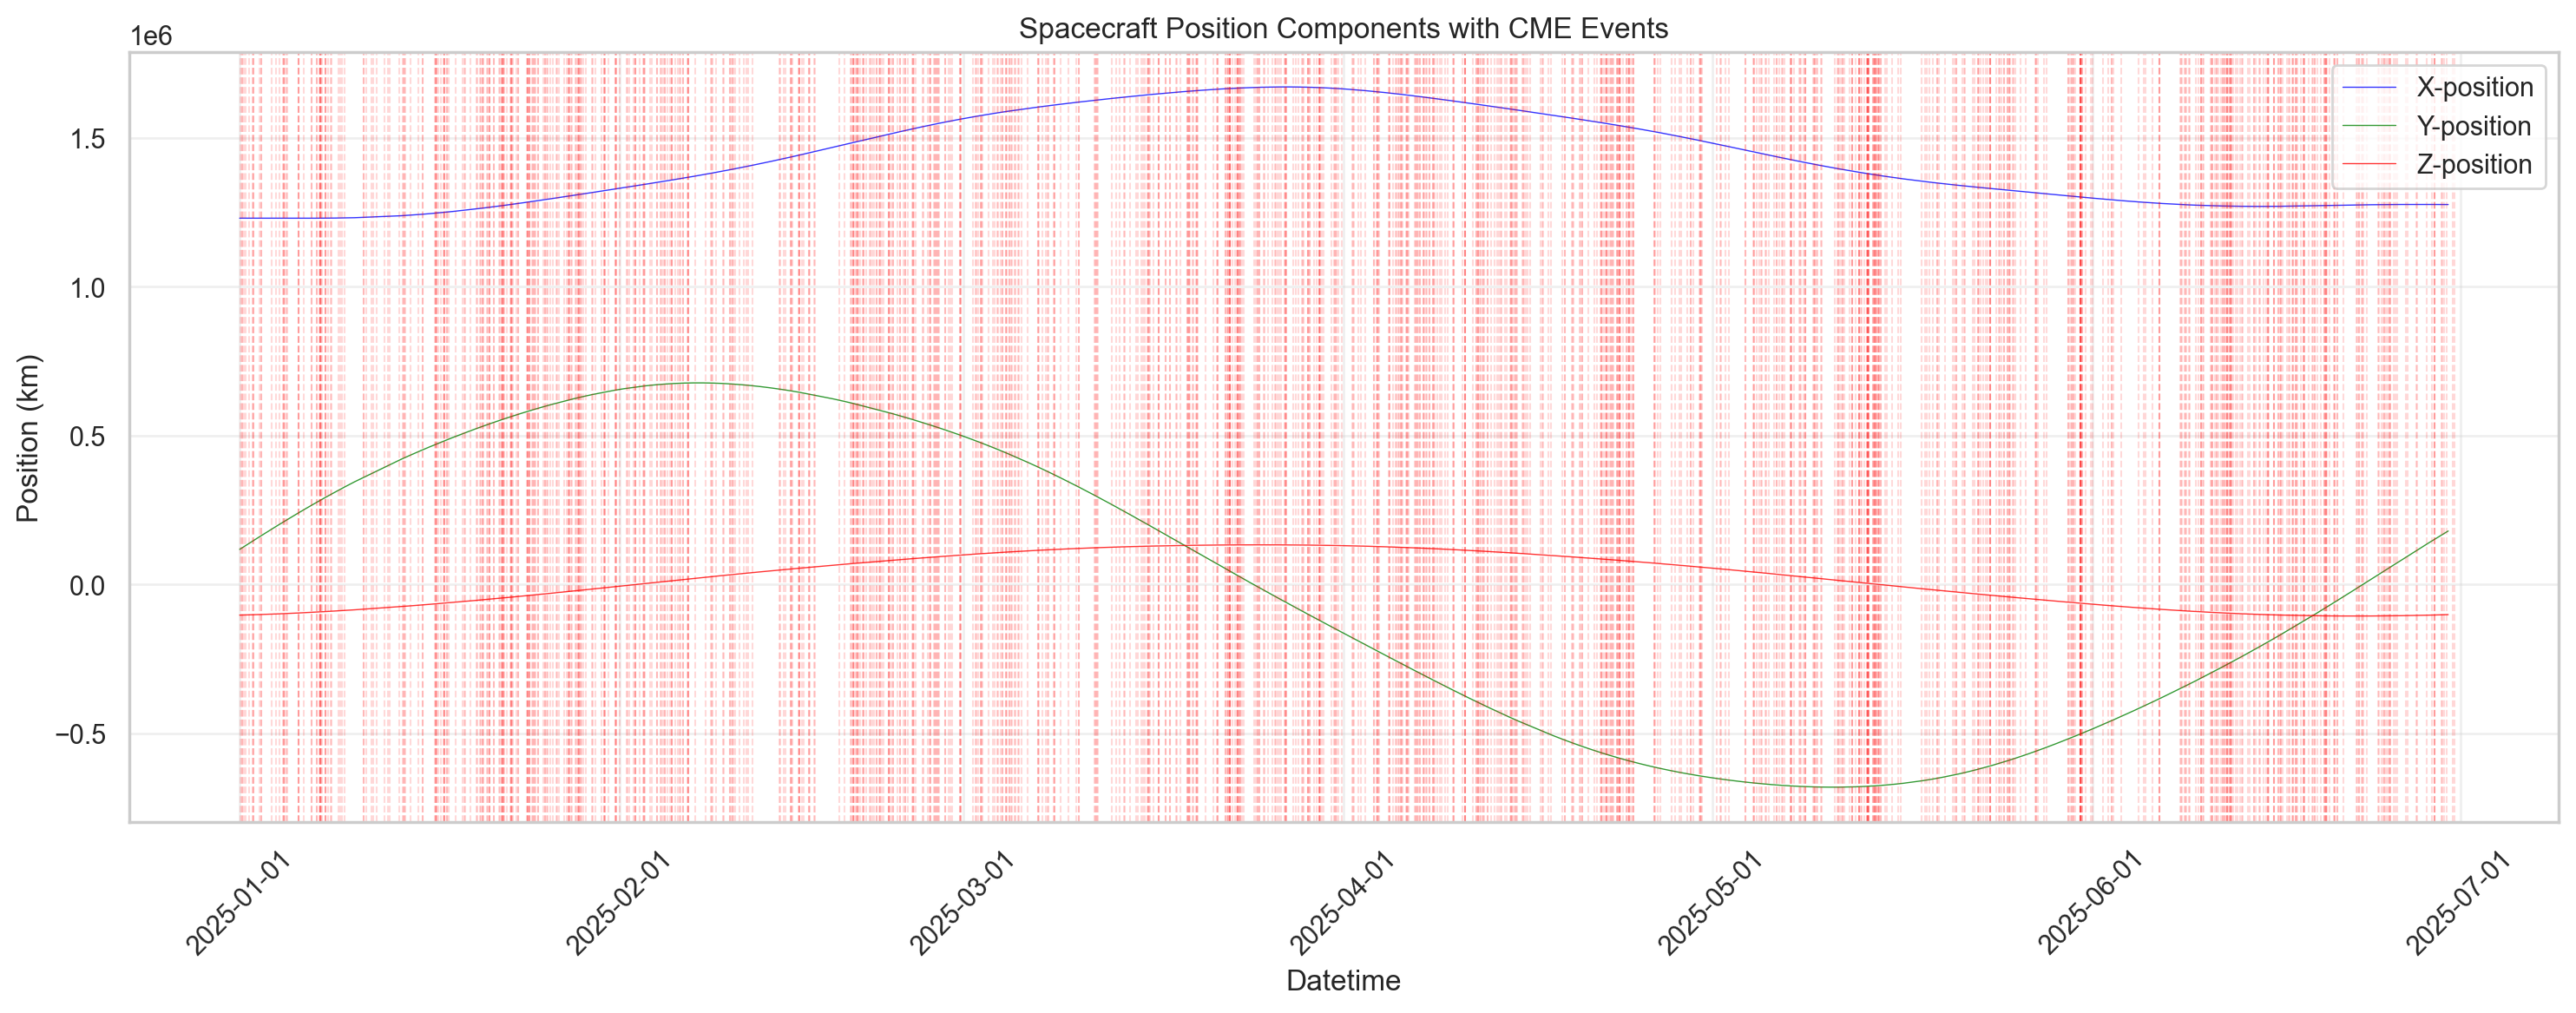


=== CME Event Summary ===
Total CME events: 964
Date range: 2025-01-01 02:00:00 to 2025-06-30 12:00:00

Monthly CME counts:
  2025-01: 173 events
  2025-02: 144 events
  2025-03: 162 events
  2025-04: 167 events
  2025-05: 164 events
  2025-06: 154 events


In [8]:
# Create main subplot with all variables
print("Creating main subplots...")
fig_main, axes_main = create_optimized_seaborn_subplots(df_cdf, df_cme, sample_rate=200)

# Create velocity components subplot
print("Creating velocity components subplot...")
fig_velocity, ax_velocity = create_velocity_components_subplot(df_cdf, df_cme, sample_rate=200)

# Create spacecraft position subplot
print("Creating spacecraft position subplot...")
fig_position, ax_position = create_spacecraft_position_subplot(df_cdf, df_cme, sample_rate=200)

# Create CME event summary
monthly_counts = create_cme_event_summary(df_cme)


Filtered data: 396032 CDF points, 167 CME events


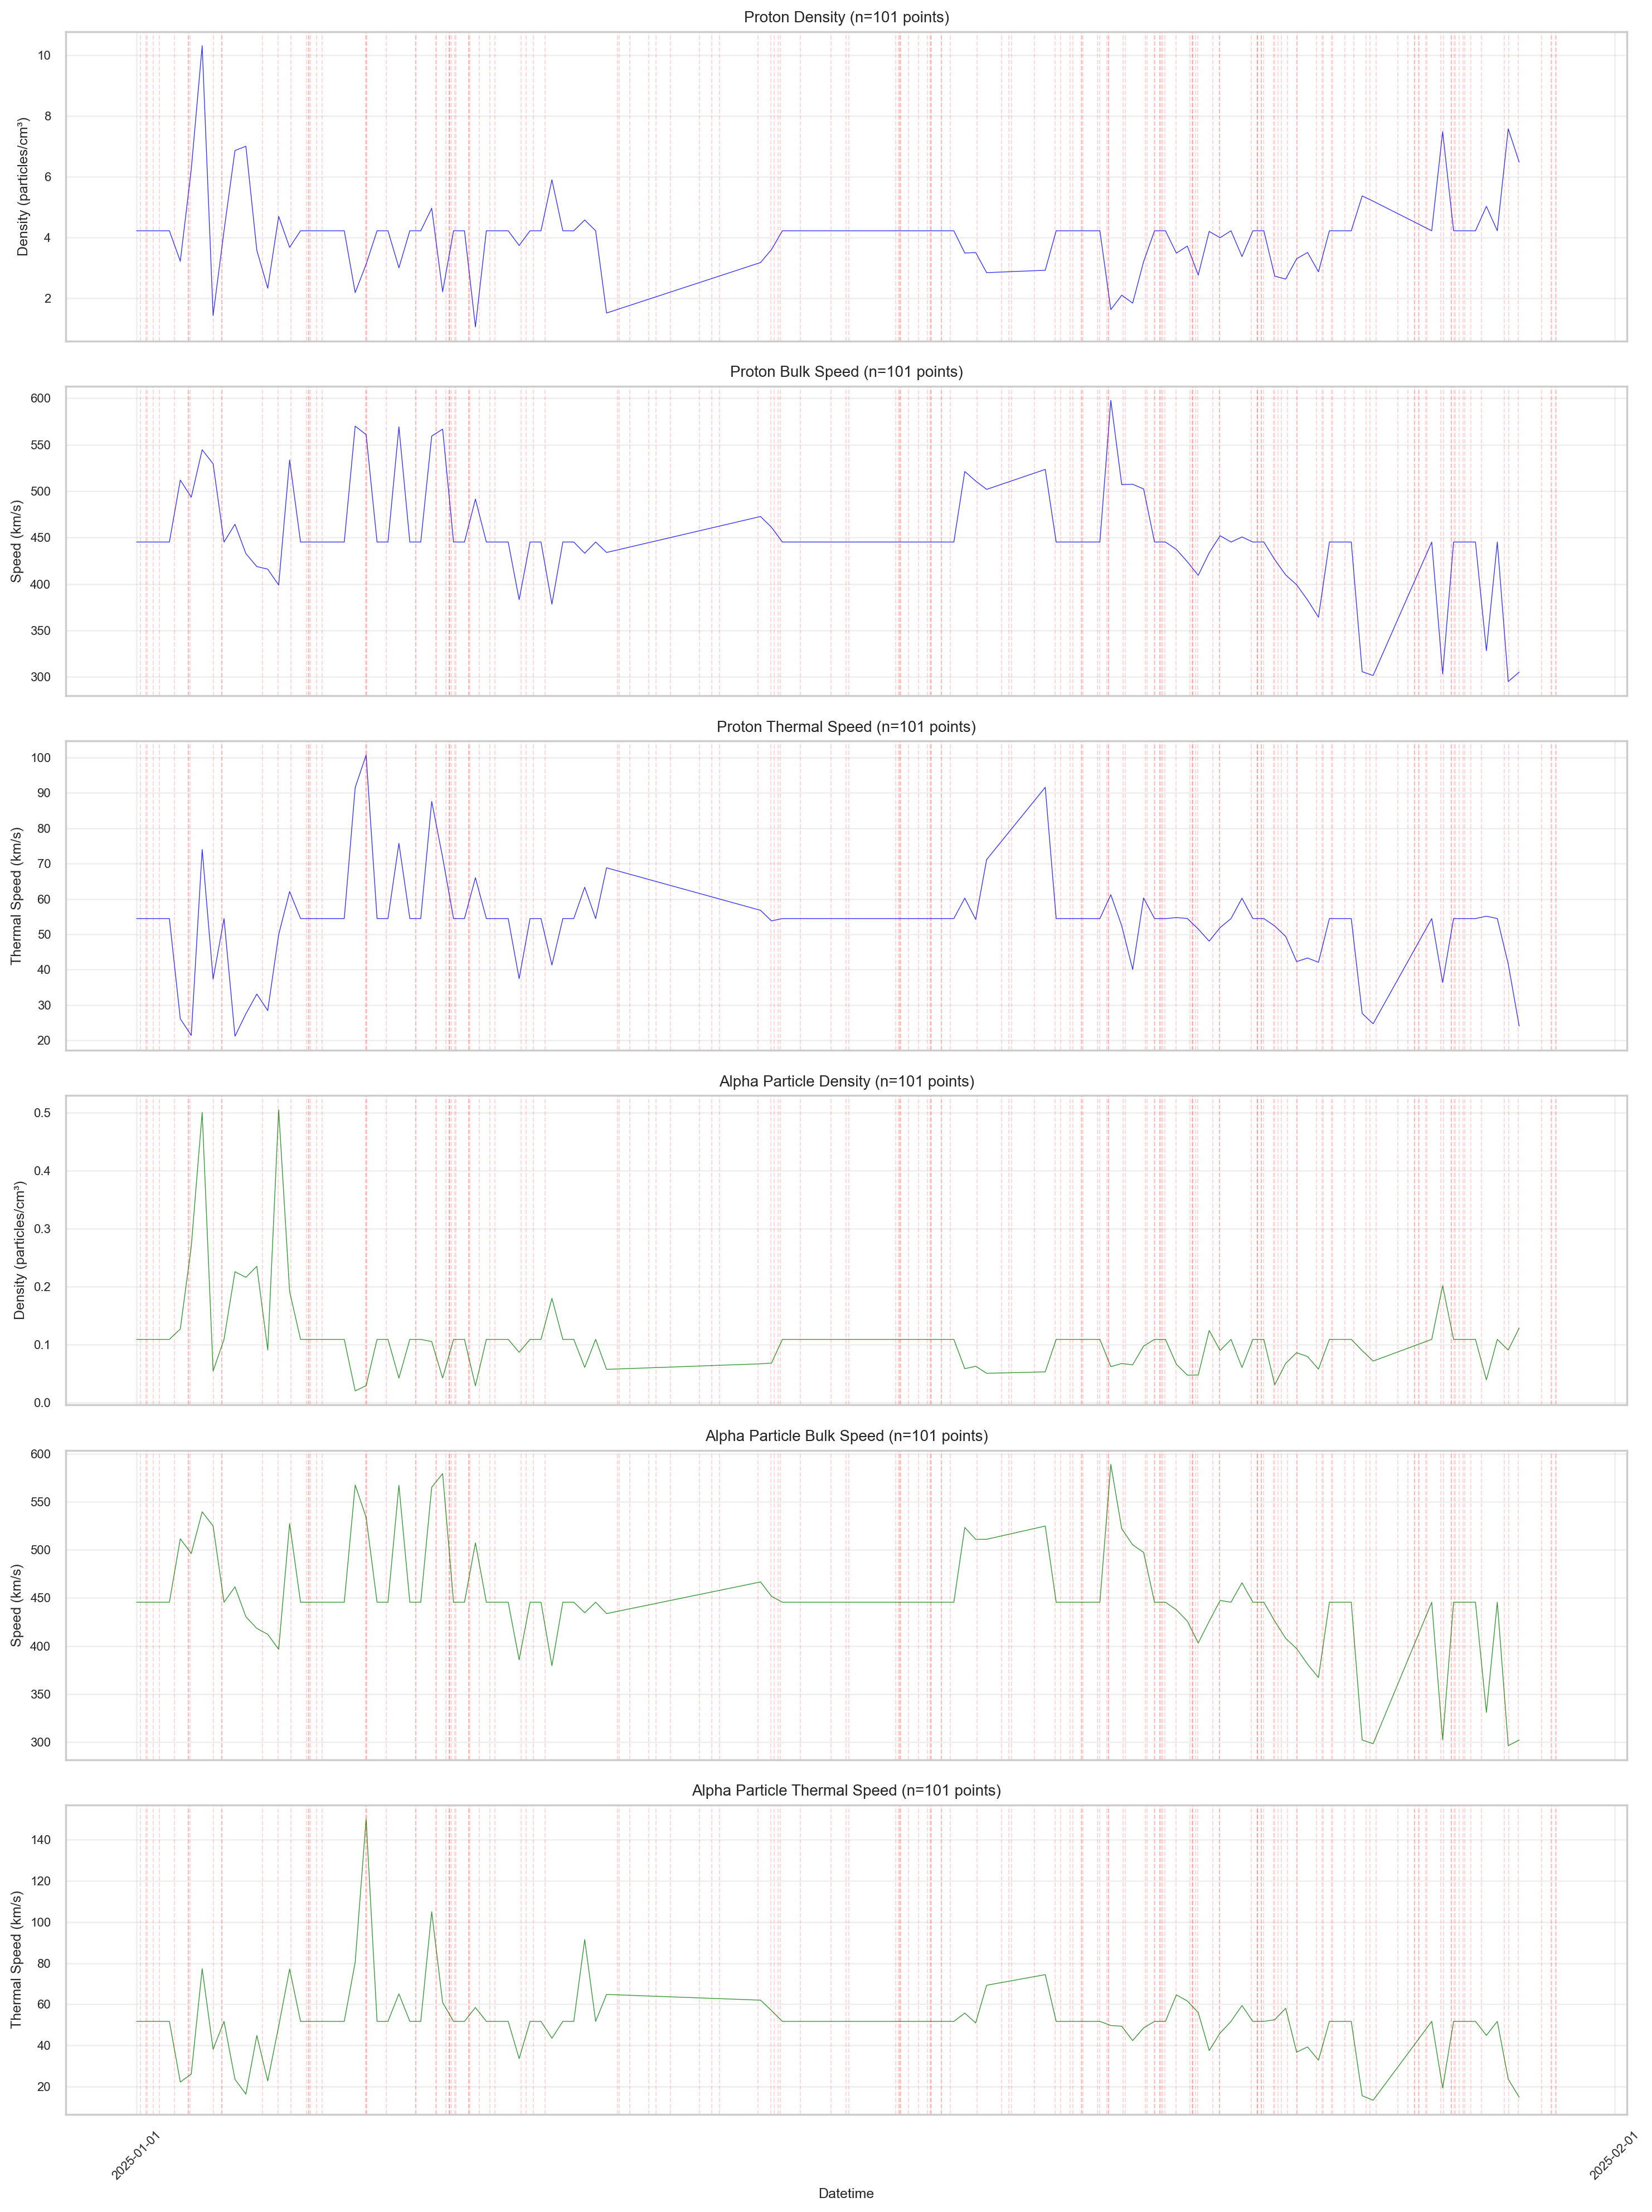

In [9]:
start_date = '2025-01-01'
end_date = '2025-01-31'
fig_filtered, axes_filtered = create_time_filtered_plots(df_cdf, df_cme, start_date, end_date)
